In [1]:
import os
import cv2
import numpy as np
from skimage.feature import hog

# Function to load images from a directory and return them as a list
def load_images_from_folder(folder_path):
    images = []
    labels = []
    for label_folder in os.listdir(folder_path):
        label_folder_path = os.path.join(folder_path, label_folder)
        for filename in os.listdir(label_folder_path):
            img_path = os.path.join(label_folder_path, filename)
            img = cv2.imread(img_path)
            img = cv2.resize(img, (128, 128))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            if img is not None:
                images.append(img)
                labels.append(label_folder)  
    return images, labels

# Load dataset
dataset_folder = '../dataset/images'
images, labels = load_images_from_folder(dataset_folder)
print(f"Loaded {len(images)} images with corresponding labels.")


Loaded 7992 images with corresponding labels.


In [ ]:
import cv2
import numpy as np
from skimage.feature import hog

def cannyEdge(img):
    img=cv2.resize(img,(128,128))
    med_value = np.median(img)
    lower = int(max(0, 0.7 * med_value))
    upper = int(min(255, 1.13 * med_value))
    blured_img = cv2.GaussianBlur(img, (7, 7), 0)
    edge = cv2.Canny(image=blured_img, threshold1=lower, threshold2=upper)
    return edge

def extract_hog_features(image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2)):
    img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (64, 64)) 
    features, hog_image = hog(img, orientations=orientations, 
                              pixels_per_cell=pixels_per_cell,
                              cells_per_block=cells_per_block, 
                              transform_sqrt=True, 
                              visualize=True, feature_vector=True)
    return features

def extract_combined_features(image):
    canny_features = cannyEdge(image)
    canny_flattened = canny_features.flatten()
    hog_features = extract_hog_features(image)
    canny_flattened = canny_flattened.astype(np.float32)
    
    combined_features = np.concatenate((canny_flattened, hog_features))
    return combined_features

features = [extract_combined_features(img) for img in images]
features_arr = np.array(features)

print(f"Features array shape: {features_arr.shape}")


In [10]:
def cannyEdge(img):
    img=cv2.resize(img,(128,128))
    med_value = np.median(img)
    lower = int(max(0, 0.7 * med_value))
    upper = int(min(255, 1.13 * med_value))
    blured_img = cv2.GaussianBlur(img, (7, 7), 0)
    edge = cv2.Canny(image=blured_img, threshold1=lower, threshold2=upper)
    return edge


In [4]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)  

In [5]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


X_train, X_test, y_train, y_test = train_test_split(features_arr, encoded_labels, test_size=0.2, random_state=42)


svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)


y_pred = svm_model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))


              precision    recall  f1-score   support

        cars       0.96      0.96      0.96       720
 motorcycles       0.95      0.91      0.93       390
non_vehicles       0.95      0.99      0.97       489

    accuracy                           0.95      1599
   macro avg       0.95      0.95      0.95      1599
weighted avg       0.95      0.95      0.95      1599



In [ ]:
def sliding_window(image, step_size, window_size):
    h, w = window_size
    image_h, image_w = image.shape[:2]
    for y in range(0, image_h, step_size):
        for x in range(0, image_w, step_size):

            window = image[y:y + h, x:x + w]
         
            if window.shape[:2] != window_size:
                continue
      
            yield (x, y, window)

def detect_vehicles_in_frame(frame, model, label_encoder,  window_size=(128, 128), step_size=32):
    detected_objects = []
    for (x, y, window) in sliding_window(frame, step_size, window_size):
        if window.shape[0] != window_size[1] or window.shape[1] != window_size[0]:
            continue
        window_features = extract_combined_features(window).reshape(1, -1)
        prediction = model.predict(window_features)
        predicted_class = label_encoder.inverse_transform(prediction)[0]
        if predicted_class == 'cars' or predicted_class=="motercycles":
            detected_objects.append((x, y, predicted_class))
            cv2.rectangle(frame, (x, y), (x + window_size[0], y + window_size[1]), (0, 255, 0), 2)
            cv2.putText(frame, predicted_class, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
    return frame, detected_objects

In [13]:
import cv2
import numpy as np

def sliding_window(image, step_size, window_size):
    h, w = window_size
    image_h, image_w = image.shape[:2]
    for y in range(0, image_h, step_size):
        for x in range(0, image_w, step_size):
            window = image[y:y + h, x:x + w]
            if window.shape[:2] == (h, w):
                yield (x, y, window)

def detect_vehicles_in_frame(frame, model, label_encoder, window_size=(128, 128), step_size=32):
    detected_objects = []
    for (x, y, window) in sliding_window(frame, step_size, window_size):
        window_features = extract_combined_features(window).reshape(1, -1)        
        prediction = model.predict(window_features)
        predicted_class = label_encoder.inverse_transform(prediction)[0]
        print(predicted_class)
        if predicted_class in ['cars', 'motorcycles']:
            detected_objects.append((x, y, predicted_class))
            cv2.rectangle(frame, (x, y), (x + window_size[0], y + window_size[1]), (0, 255, 0), 2)
            cv2.putText(frame, predicted_class, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

    return frame, detected_objects

def process_video(input_path, output_path, model, label_encoder, window_size=(375, 375), step_size=100):
    cap = cv2.VideoCapture(input_path)
    if not cap.isOpened():
        print(f"Error: Couldn't open video file {input_path}")
        return

    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))

    # Use a different codec if DIVX is unsupported
    writer = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'DIVX'), fps, (width, height))

    frame_idx = 0
    while cap.isOpened():
        print(f"Processing frame: {frame_idx}")
        ret, frame = cap.read()
        if not ret:
            print(f"End of video at frame {frame_idx}")
            break

        frame, detected_objects = detect_vehicles_in_frame(frame, model, label_encoder, window_size, step_size)

        writer.write(frame)
        frame_idx += 1

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    writer.release()
    cv2.destroyAllWindows()
    print(f"Video processing complete. Output saved to {output_path}")

# Example usage (ensure model and label_encoder are defined properly)
process_video('../dataset/sample videos/sample.mp4', 'canny_hog_prediction.mp4', svm_model, label_encoder)


Processing frame: 0
non_vehicles
cars
cars
cars
cars
cars
cars
non_vehicles
non_vehicles
motorcycles
non_vehicles
cars
motorcycles
non_vehicles
cars
cars
non_vehicles
cars
cars
cars
non_vehicles
cars
cars
cars
cars
cars
cars
cars
cars
cars
cars
cars
cars
cars
cars
cars
non_vehicles
cars
cars
cars
cars
cars
cars
cars
cars
cars
cars
cars
cars
cars
cars
cars
cars
cars
cars
cars
cars
cars
cars
cars
cars
cars
cars
cars
cars
cars
cars
cars
cars
non_vehicles
motorcycles
cars
cars
cars
cars
cars
cars
cars
cars
cars
cars
cars
cars
cars
cars
cars
cars
cars
cars
cars
cars
cars
cars
cars
cars
non_vehicles
cars
cars
cars
motorcycles
cars
cars
cars
cars
cars
cars
cars
cars
cars
cars
cars
motorcycles
cars
cars
motorcycles
cars
cars
cars
cars
cars
cars
motorcycles
cars
cars
cars
cars
motorcycles
cars
cars
cars
cars
cars
cars
cars
cars
cars
cars
cars
cars
cars
cars
non_vehicles
cars
non_vehicles
non_vehicles
cars
cars
cars
motorcycles
motorcycles
cars
cars
cars
cars
cars
cars
cars
cars
cars
cars
cars
c

KeyboardInterrupt: 

In [16]:
def pyramid(image, scale=1.5, min_size=(40, 40)):
    yield image

    # Generate pyramid levels until minimum size is reached
    while True:
        # Calculate the new image size based on
        # the scale factor and resize the image
        w = int(image.shape[1] / scale)
        h = int(image.shape[0] / scale)
        image = cv2.resize(image, (w, h))

        # If the new level is too small, stop generating more levels
        if image.shape[0] < min_size[1] or image.shape[1] < min_size[0]:
            break

        yield image


def sliding_window(image, step_size, window_size):
    # get the window and image sizes
    h, w = window_size
    image_h, image_w = image.shape[:2]

    # loop over the image, taking steps of size `step_size`
    for y in range(0, image_h, step_size):
        for x in range(0, image_w, step_size):
            # define the window
            window = image[y:y + h, x:x + w]
            # if the window is below the minimum window size, ignore it
            if window.shape[:2] != window_size:
                continue
            # yield the current window
            yield (x, y, window)


image = cv2.imread("./main_video_frames/frame8.jpg")

w, h = 375, 375

for resized in pyramid(image):
    for (x, y, window) in sliding_window(resized, step_size=100, window_size=(w, h)):

        # Extract combined features for the window
        # Get the number of features the model expects
        features = extract_combined_features(window).reshape(1, -1)
        prediction = svm_model.predict(features)
        predicted_class = label_encoder.inverse_transform(prediction)[0]
        print(predicted_class)
        if predicted_class== "cars" or predicted_class == "motorcycles":
            clone = resized.copy()
            cv2.rectangle(clone, (x, y), (x + w, y + h), (0, 255, 0), 2)
            cv2.putText(clone, predicted_class, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
            small_clone = cv2.resize(clone, (clone.shape[1] // 2, clone.shape[0] // 2))
            cv2.imshow("Window", small_clone)
            cv2.waitKey(100)

cv2.destroyAllWindows()

non_vehicles
cars
cars
cars
cars
motorcycles
cars
non_vehicles
non_vehicles
non_vehicles
non_vehicles
non_vehicles
motorcycles
non_vehicles
non_vehicles
non_vehicles
non_vehicles
non_vehicles
cars
cars
non_vehicles
cars
non_vehicles
non_vehicles
non_vehicles
cars
non_vehicles
non_vehicles
non_vehicles
non_vehicles
cars
non_vehicles
non_vehicles
non_vehicles
non_vehicles
cars
non_vehicles
non_vehicles
non_vehicles
cars
non_vehicles
non_vehicles
cars
cars
cars
cars
cars
cars
cars
non_vehicles
cars
cars
cars
cars
cars
cars
cars
cars
cars
non_vehicles
non_vehicles
non_vehicles
non_vehicles
cars
non_vehicles
non_vehicles
motorcycles
cars
non_vehicles
non_vehicles
non_vehicles
non_vehicles
non_vehicles
motorcycles
motorcycles
cars
cars
cars
cars
non_vehicles
non_vehicles
non_vehicles
non_vehicles
motorcycles
non_vehicles
cars
non_vehicles
non_vehicles
non_vehicles
non_vehicles
non_vehicles
cars
non_vehicles
non_vehicles
cars
non_vehicles
cars
motorcycles
non_vehicles
non_vehicles
non_vehicle

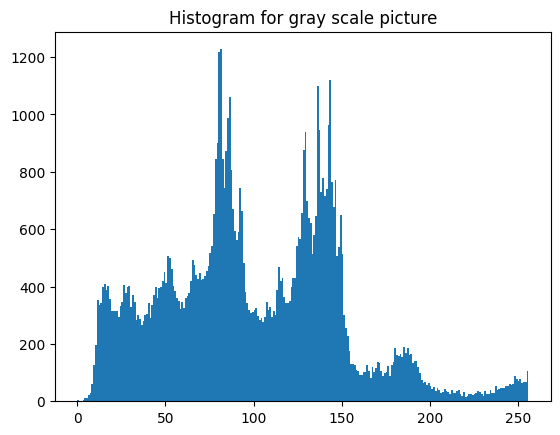

KeyboardInterrupt: 

In [17]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

gray_img = cv2.imread('../dataset/images/cars/1052.jpg', cv2.IMREAD_GRAYSCALE)
cv2.imshow('RICHEST MAN',gray_img)
hist = cv2.calcHist([gray_img],[0],None,[256],[0,256])
plt.hist(gray_img.ravel(),256,[0,256])
plt.title('Histogram for gray scale picture')
plt.show()

while True:
    k = cv2.waitKey(0) & 0xFF
    if k == 27: break             # ESC key to exit
cv2.destroyAllWindows()

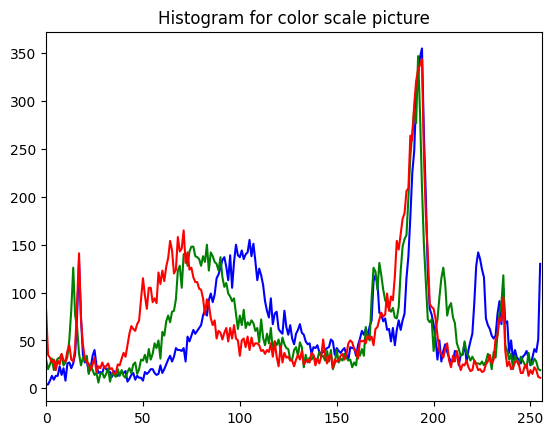

KeyboardInterrupt: 

In [19]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

img = cv2.imread('../dataset/images/cars/grid_10_cars.png', -1)
cv2.imshow('GoldenGate',img)

color = ('b','g','r')
for channel,col in enumerate(color):
    histr = cv2.calcHist([img],[channel],None,[256],[0,256])
    plt.plot(histr,color = col)
    plt.xlim([0,256])
plt.title('Histogram for color scale picture')
plt.show()

while True:
    k = cv2.waitKey(0) & 0xFF
    if k == 27: break             # ESC key to exit
cv2.destroyAllWindows()

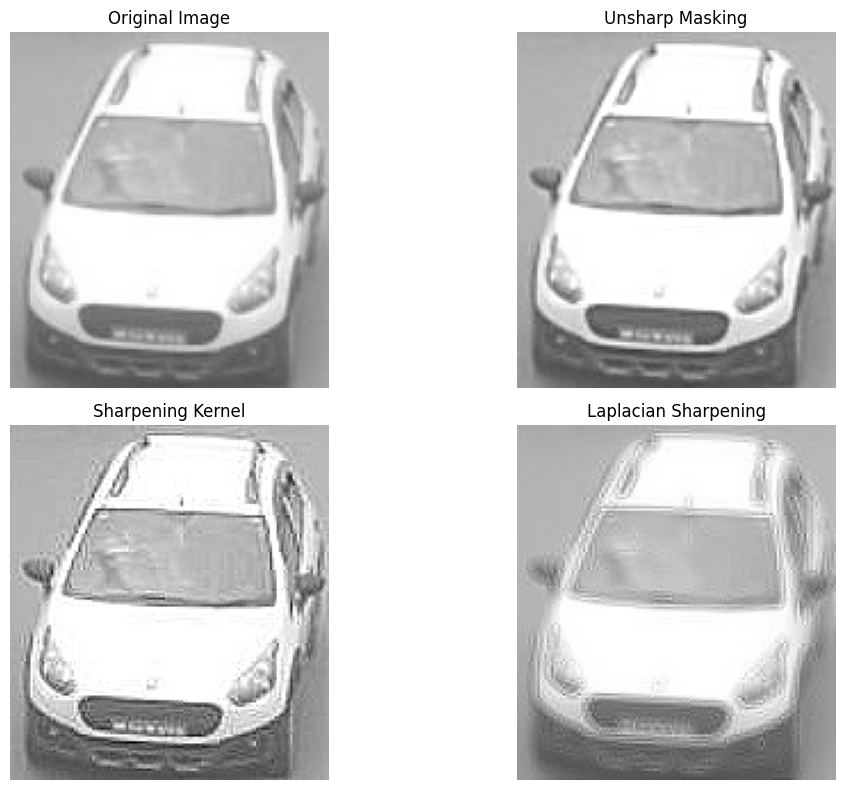

In [22]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def unsharp_masking(image):
    # Gaussian blur
    blurred = cv2.GaussianBlur(image, (9, 9), 10)
    # Unsharp masking: original + scaled difference with blurred
    sharpened = cv2.addWeighted(image, 1.5, blurred, -0.5, 0)
    return sharpened

def sharpening_kernel(image):
    # Sharpening kernel
    kernel = np.array([[0, -1, 0],
                       [-1, 5, -1],
                       [0, -1, 0]])
    # Apply kernel
    sharpened = cv2.filter2D(image, -1, kernel)
    return sharpened

def laplacian_sharpening(image):
    # Laplacian operator for edge detection
    laplacian = cv2.Laplacian(image, cv2.CV_64F)
    # Sharpen by adding Laplacian result to original
    sharpened = cv2.convertScaleAbs(image + laplacian)
    return sharpened

# Load the input image
image = cv2.imread('../dataset/images/cars/1011.jpg')

# Apply sharpening techniques
unsharp_img = unsharp_masking(image)
kernel_img = sharpening_kernel(image)
laplacian_img = laplacian_sharpening(image)

# Convert BGR to RGB for matplotlib display
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
unsharp_rgb = cv2.cvtColor(unsharp_img, cv2.COLOR_BGR2RGB)
kernel_rgb = cv2.cvtColor(kernel_img, cv2.COLOR_BGR2RGB)
laplacian_rgb = cv2.cvtColor(laplacian_img, cv2.COLOR_BGR2RGB)

# Display images using matplotlib for comparison
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.imshow(image_rgb)
plt.title('Original Image')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(unsharp_rgb)
plt.title('Unsharp Masking')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(kernel_rgb)
plt.title('Sharpening Kernel')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(laplacian_rgb)
plt.title('Laplacian Sharpening')
plt.axis('off')

plt.tight_layout()
plt.show()


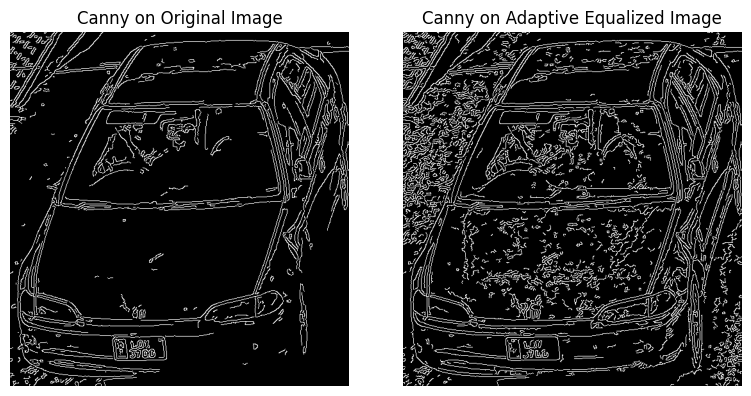

In [35]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import exposure
image=cv2.imread("../dataset/images/cars/1078.jpg")
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

def cannyEdge(img):
    med_value = np.median(img)
    lower = int(max(0, 0.7 * med_value))
    upper = int(min(255, 1.13 * med_value))
    blured_img = cv2.GaussianBlur(img, (7, 7), 0)
    edge = cv2.Canny(image=blured_img, threshold1=lower, threshold2=upper)
    
    return edge

# Apply Adaptive Histogram Equalization
image_adapteq = exposure.equalize_adapthist(image_gray, clip_limit=0.05)

# Apply Canny Edge Detection on both original and equalized images
image_adapteq_canny = cannyEdge((image_adapteq * 255).astype(np.uint8))  # Ensure image is in 8-bit range for Canny
image_gray_canny = cannyEdge(image_gray)

# Plotting the results
fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

axes[0].imshow(image_gray_canny, cmap=plt.cm.gray)
axes[0].set_title('Canny on Original Image')

axes[1].imshow(image_adapteq_canny, cmap=plt.cm.gray)
axes[1].set_title('Canny on Adaptive Equalized Image')

# Remove axis labels for all plots
for ax in axes:
    ax.axis('off')

# Display the results
plt.tight_layout()
plt.show()